In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from data.prep import get_data_as_dataframe
from utils.data_utils import custom_train_test_split, calculate_mean_std

from models.vit import ViT

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.train_utils import EarlyStopping
from engine import train, eval

from plots import plot_metrics_curve, plot_conf_matrix, plot_precision_recall_curve, plot_roc_curve

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [2]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = True

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [3]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

# Dataset name
DATASET_NAME = 'SDNET2018'

df = get_data_as_dataframe(DATA_PATH, dataset_name=DATASET_NAME, balance=True)
df.head()

,image,label
0,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
1,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
2,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
3,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
4,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked


In [4]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4172, 2)
Validation size: (783, 2)
Test size: (261, 2)


In [5]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    2086
cracked        2086
Name: label, dtype: int64

Validation data balance:
 non-cracked    392
cracked        391
Name: label, dtype: int64

Test data balance:
 cracked        131
non-cracked    130
Name: label, dtype: int64



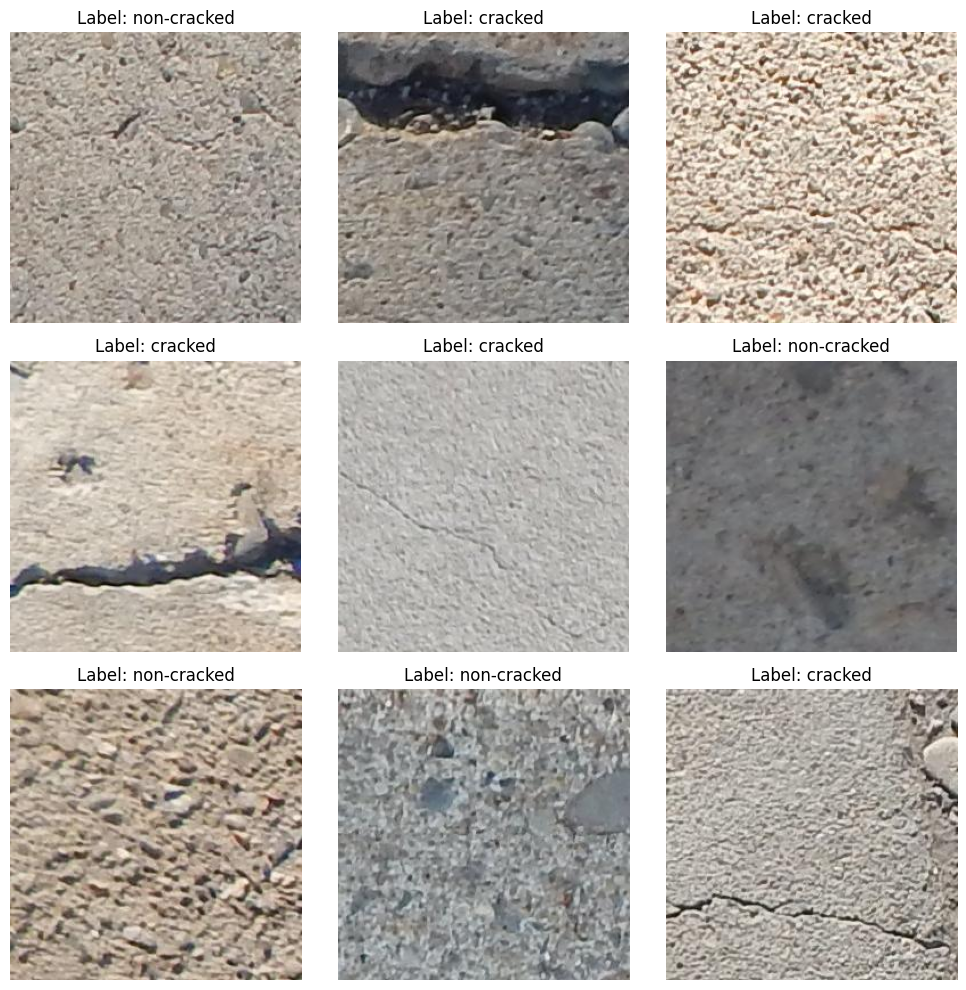

In [6]:
from plots import show_df

show_df(df=df, n_samples=9)

# Initialize Dataset and Dataloader for Training

In [7]:
class CrackDataset(Dataset):
    def __init__(self, df, dataset_name, transform=None):
        super().__init__()
        self.df_data = df.values
        self.dataset_name = dataset_name
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 64

if PRETRAINED:
    MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
else:
    MEAN, STD = calculate_mean_std(train_df.copy())

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD), 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: 64


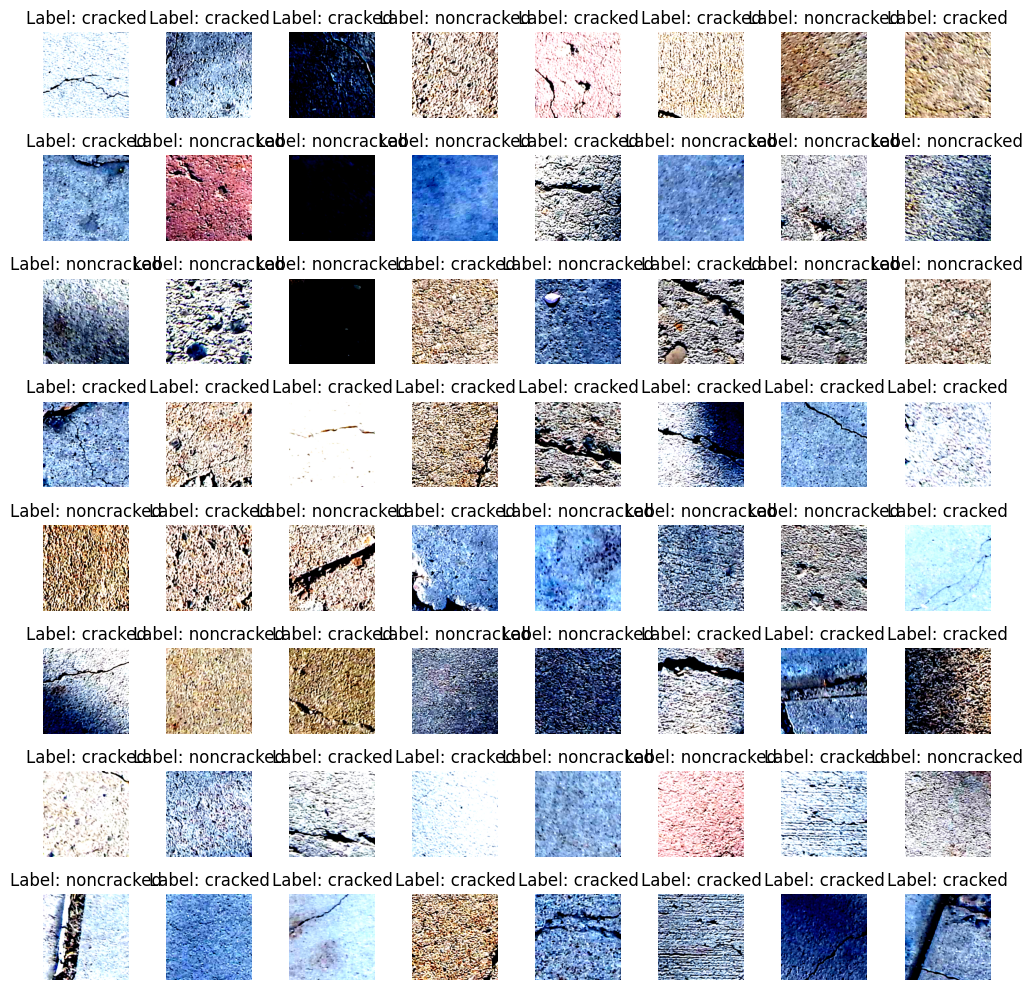

In [9]:
from plots import show_dl

show_dl(dataloaders['train'])

# ViT (Vision Transformer) Architecture

In [10]:
num_classes = len(df.label.unique())
model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=False, trainable_layers=6)

In [11]:
model

ViT(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((

In [12]:
for layer, param in model.named_parameters():
    if param.requires_grad:
        print(layer)

model.class_token
model.conv_proj.weight
model.conv_proj.bias
model.encoder.pos_embedding
model.encoder.layers.encoder_layer_0.ln_1.weight
model.encoder.layers.encoder_layer_0.ln_1.bias
model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight
model.encoder.layers.encoder_layer_0.self_attention.in_proj_bias
model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight
model.encoder.layers.encoder_layer_0.self_attention.out_proj.bias
model.encoder.layers.encoder_layer_0.ln_2.weight
model.encoder.layers.encoder_layer_0.ln_2.bias
model.encoder.layers.encoder_layer_0.mlp.0.weight
model.encoder.layers.encoder_layer_0.mlp.0.bias
model.encoder.layers.encoder_layer_0.mlp.3.weight
model.encoder.layers.encoder_layer_0.mlp.3.bias
model.encoder.layers.encoder_layer_1.ln_1.weight
model.encoder.layers.encoder_layer_1.ln_1.bias
model.encoder.layers.encoder_layer_1.self_attention.in_proj_weight
model.encoder.layers.encoder_layer_1.self_attention.in_proj_bias
model.encoder.layers.encoder

# Fine-tune ViT

In [13]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 2.5e-4
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)
# optimizer = optim.Adam(params_to_tune, lr=INIT_LR, weight_decay=1e-5)

# Update learning rate once validation loss stop decreasing
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-5)

early_stopping = EarlyStopping(patience=5)

In [21]:
import os
import csv
import yaml
import numpy as np
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score

from utils.eval_utils import classification_report
from plots import plot_metrics_curve, plot_conf_matrix, plot_precision_recall_curve, plot_roc_curve

from typing import Optional, Callable, Tuple, Dict

BAR_FORMAT = '{desc}: {percentage:3.0f}%| {bar} | {n_fmt}/{total_fmt} {unit}'

def train_one_epoch(
    model: nn.Module, 
    train_loader: DataLoader, 
    criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    optimizer: torch.optim.Optimizer, 
    device: torch.device, 
    verbose: bool) -> Tuple[float, float, float, float, float]:

    # Set the model to train mode
    model.train()

    y_pred = []
    y_true = []

    running_loss = 0.0
    with tqdm(total=len(train_loader), desc="\tTrain", unit='', bar_format=BAR_FORMAT, disable=not verbose) as pbar:
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(torch.exp(outputs), 1)
            y_pred.extend(preds.data.cpu().numpy()) # Save Predictions
            y_true.extend(labels.data.cpu().numpy()) # Save Actual

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss
            running_loss += loss.item() * inputs.size(0)

            pbar.update()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(y_true, y_pred)
        train_precision = precision_score(y_true, y_pred, average='micro')
        train_recall = recall_score(y_true, y_pred, average='micro')
        train_f1 = f1_score(y_true, y_pred, average='micro')

        pbar.unit = f'| Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}% ' \
                    f'| Precision: {train_precision*100:.2f}% | Recall: {train_recall*100:.2f}% ' \
                    f'| F1 score: {train_f1*100:.2f}%'

    return train_loss, train_acc, train_precision, train_recall, train_f1

def eval(
    model: nn.Module, 
    val_loader: DataLoader,
    criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
    device: torch.device, 
    verbose: bool,  
    evaluate: bool = False,
    print_report: bool = False) -> Tuple[float, float, float, float, float]:

    # Set the model to evaluation mode
    model.eval()  

    y_pred = []
    y_score = []
    y_true = []
    running_loss = 0.0

    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="\tValidation", unit='', bar_format=BAR_FORMAT, disable=not verbose) as pbar:
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(torch.exp(outputs), 1)
                y_pred.extend(preds.data.cpu().numpy())
                y_score.extend(outputs.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

                # Calculate loss
                loss = criterion(outputs, labels)

                # Update the running loss
                running_loss += loss.item() * inputs.size(0)
            
                pbar.update()
                
            val_loss = running_loss / len(val_loader.dataset)
            val_acc = accuracy_score(y_true, y_pred)
            val_precision = precision_score(y_true, y_pred, average='micro')
            val_recall = recall_score(y_true, y_pred, average='micro')
            val_f1 = f1_score(y_true, y_pred, average='micro')

            pbar.unit = f'| Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}% ' \
                        f'| Precision: {val_precision*100:.2f}% | Recall: {val_recall*100:.2f}% ' \
                        f'| F1 score: {val_f1*100:.2f}%'

    if evaluate:
        if print_report:        
            print(classification_report(y_true, y_pred))

        return y_true, y_pred, y_score

    else:
        return val_loss, val_acc, val_precision, val_recall, val_f1

def train(
    model: nn.Module, 
    NUM_EPOCHS: int, 
    dataloaders: Dict[str, DataLoader], 
    device: torch.device, 
    criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
    optimizer: torch.optim.Optimizer, 
    scheduler=None, 
    early_stopping=None, 
    checkpoint_interval: Optional[int] = None, 
    multiple_gpu: bool = False,
    save: bool = True,
    save_dir: Path = None,
    verbose: bool = True) -> dict:

    train_hist = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': []
    }

    # Train in multiple gpus
    if multiple_gpu:
        model = torch.nn.DataParallel(model, device_ids=[0, 1])

    if save:
        # Init training params
        hyps = {
            'criterion': type(criterion).__name__,
            'optimizer': type(optimizer).__name__, 
        }

        if hyps['optimizer'] == 'SGD':
            hyps['opt_learning_rate'] = optimizer.param_groups[0]['lr'] 
            hyps['opt_momentum'] = optimizer.param_groups[0]['momentum']
            hyps['opt_weight_decay'] = optimizer.param_groups[0]['weight_decay']
        
        if hyps['optimizer'] == 'Adam':
            hyps['opt_learning_rate'] = optimizer.param_groups[0]['lr'] 
            hyps['opt_weight_decay'] = optimizer.param_groups[0]['weight_decay']
        
        if scheduler:
            hyps['scheduler'] = type(scheduler).__name__
            hyps['scheduler_factor'] = scheduler.factor
            hyps['scheduler_patience'] = scheduler.patience
            hyps['scheduler_threshold'] = scheduler.threshold

        opts = {
            'epochs': NUM_EPOCHS,
            'dataset': dataloaders['train'].dataset.dataset_name,
            'dataset_size': len(dataloaders['train'].dataset) + len(dataloaders['valid'].dataset) + len(dataloaders['test'].dataset),
            'batch_size': dataloaders['train'].batch_size,
            'imgsz': dataloaders['train'].dataset.transform.transforms[0].size,
            'model_name': model.model_name,
            'pretrained': model.pretrained,
            'trainable_layers': model.trainable_layers,
            'device': device,
            'multiple_gpu': multiple_gpu,
            'hyps': hyps,          
        }
        
        # Init experiments folder
        if save_dir is None:
            now = datetime.now().strftime("%Y-%m-%d %H-%M")
            save_dir = f"experiments/({now}) {opts['model_name']}_on_{opts['dataset']}_w_epoch_{opts['epochs']}_lr_{hyps['opt_learning_rate']}"
        os.makedirs(save_dir, exist_ok=True)

        # Save training params
        opts_path = os.path.join(save_dir, 'opt.yaml')
        with open(opts_path, 'w') as f:
            yaml.dump(opts, f, sort_keys=False)

    best_val_loss = float('inf')

    for epoch in range(NUM_EPOCHS):

        if verbose:
            lr = optimizer.param_groups[0]['lr']
            memory_usage = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | Learning Rate: {lr} | mem: {memory_usage}')

        train_loss, train_acc, train_precision, train_recall, _ = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device, verbose)
        val_loss, val_acc, val_precision, val_recall, _ = eval(model, dataloaders['valid'], criterion, device, verbose)
            
        train_hist['train_loss'].append(train_loss)
        train_hist['train_accuracy'].append(train_acc)
        train_hist['train_precision'].append(train_precision)
        train_hist['train_recall'].append(train_recall)
        
        train_hist['val_loss'].append(val_loss)
        train_hist['val_accuracy'].append(val_acc)
        train_hist['val_precision'].append(val_precision)
        train_hist['val_recall'].append(val_recall)

        # Adjust learning rate
        if scheduler:
            if hyps['scheduler']=='ReduceLROnPlateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save checkpoint
        if checkpoint_interval:
            checkpoints_dir = os.path.join(save_dir, 'checkpoints') 
            os.makedirs(checkpoints_dir, exist_ok=True)
            if (epoch + 1) % checkpoint_interval == 0:
                checkpoint_state = OrderedDict([
                    ('model_state_dict', model.state_dict()),
                    ('optimizer_state_dict', optimizer.state_dict()),
                    ('epoch', epoch + 1),
                ])
                torch.save(checkpoint_state, os.path.join(checkpoints_dir, f'checkpoint_{epoch+1}.pt'))
        
        if save:
            # Save best model
            weights_dir = os.path.join(save_dir, 'weights') 
            os.makedirs(weights_dir, exist_ok=True)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(weights_dir, 'best.pt'))
        
            # Save last model
            torch.save(model.state_dict(), os.path.join(weights_dir, 'last.pt'))

            # Save training epoch    
            csv_path = os.path.join(save_dir, 'history.csv')

            fields = ['epoch'] + list(train_hist.keys())
            data = [epoch+1, 
                    train_loss, train_acc, train_precision, train_recall, 
                    val_loss, val_acc, val_precision, val_recall]

            header = ','.join(['%20s' % field for field in fields]) + '\n'
            s = '' if os.path.exists(csv_path) else header # add header
            with open(csv_path, 'a') as f:
                row = ','.join(['%20.5g' % d for d in data])
                f.write(s + row + '\n')
        
        # Check early stop
        if early_stopping is not None:
            if early_stopping(val_loss):
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

    if save:
        plot_metrics_curve(train_hist, plot=False, save=True, save_dir=save_dir)

        y_true, y_pred, y_score = eval(model, dataloaders['valid'], criterion, device, verbose=False, evaluate=True)
        plot_conf_matrix(y_true, y_pred, classes=['non-cracked', 'cracked'], plot=False, save=True, save_dir=save_dir)
        plot_precision_recall_curve(y_true, y_score, plot=False, save=True, save_dir=save_dir)
        plot_roc_curve(y_true, y_score, plot=False, save=True, save_dir=save_dir)
    
    return train_hist

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

NUM_EPOCHS = 5

train_hist = train(model, NUM_EPOCHS, dataloaders, DEVICE, criterion, optimizer, save=True, multiple_gpu=True, verbose=True)

Epoch [1/5] | Learning Rate: 0.00025 | mem: 4637


	Train: 100%| ██████████ | 66/66 | Loss: 0.6081 | Accuracy: 66.97% | Precision: 66.97% | Recall: 66.97% | F1 score: 66.97%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.6092 | Accuracy: 66.41% | Precision: 66.41% | Recall: 66.41% | F1 score: 66.41%


Epoch [2/5] | Learning Rate: 0.00025 | mem: 4637


	Train: 100%| ██████████ | 66/66 | Loss: 0.5859 | Accuracy: 68.79% | Precision: 68.79% | Recall: 68.79% | F1 score: 68.79%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.5908 | Accuracy: 69.22% | Precision: 69.22% | Recall: 69.22% | F1 score: 69.22%


Epoch [3/5] | Learning Rate: 0.00025 | mem: 4637


	Train: 100%| ██████████ | 66/66 | Loss: 0.5767 | Accuracy: 69.25% | Precision: 69.25% | Recall: 69.25% | F1 score: 69.25%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.5883 | Accuracy: 68.58% | Precision: 68.58% | Recall: 68.58% | F1 score: 68.58%


Epoch [4/5] | Learning Rate: 0.00025 | mem: 4637


	Train: 100%| ██████████ | 66/66 | Loss: 0.5820 | Accuracy: 69.68% | Precision: 69.68% | Recall: 69.68% | F1 score: 69.68%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.5956 | Accuracy: 67.31% | Precision: 67.31% | Recall: 67.31% | F1 score: 67.31%


Epoch [5/5] | Learning Rate: 0.00025 | mem: 4637


	Train: 100%| ██████████ | 66/66 | Loss: 0.5595 | Accuracy: 71.62% | Precision: 71.62% | Recall: 71.62% | F1 score: 71.62%
	Validation: 100%| ██████████ | 13/13 | Loss: 0.5753 | Accuracy: 69.48% | Precision: 69.48% | Recall: 69.48% | F1 score: 69.48%


In [83]:
# Create train history csv
epoch = 1

train_loss = 0.1
train_acc = 0.8
train_precision = 0.8
train_recall = 0.8

val_loss = 0.2
val_acc = 0.7
val_precision = 0.7
val_recall = 0.7



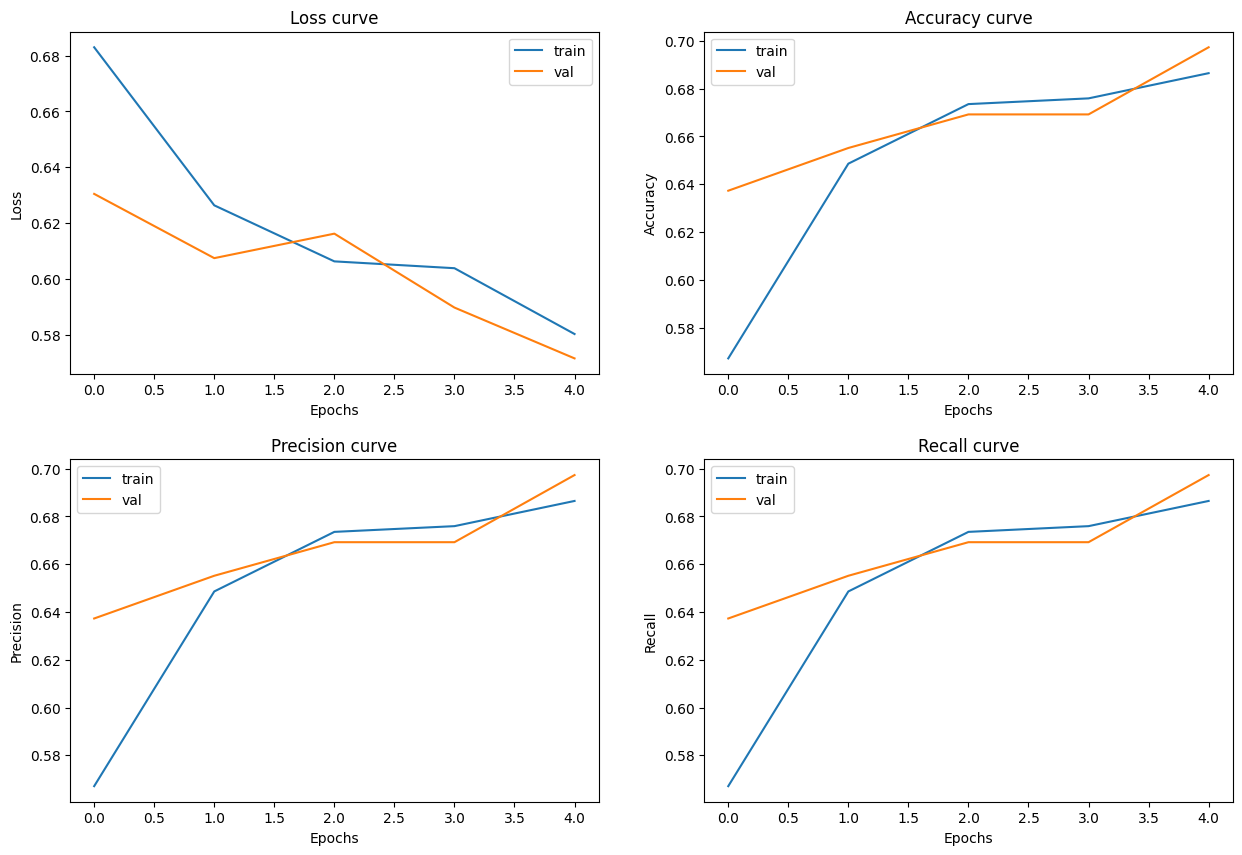

In [16]:
plot_metrics_curve(train_hist)

# Evaluation

In [17]:
y_true, y_pred, y_score = eval(model, dataloaders['test'], criterion, device=DEVICE, verbose=False, evaluate=True, print_report=True)

           class | support   | precision | recall    | f1-score  | avg-precision | roc-auc-score | log-loss  |
---------------------------------------------------------------------------------------------------------------
               0 | 130       | 0.70      | 0.76      | 0.73      | -             | -             | -         |
               1 | 131       | 0.74      | 0.67      | 0.70      | -             | -             | -         |
---------------------------------------------------------------------------------------------------------------
accuracy (micro) | 261       | 0.72      | 0.72      | 0.72      | 0.66          | 0.72          | 10.22     |
       macro avg | 261       | 0.72      | 0.72      | 0.72      | 0.66          | 0.72          | 10.22     |
    weighted avg | 261       | 0.72      | 0.72      | 0.72      | 0.66          | 0.72          | 10.22     |



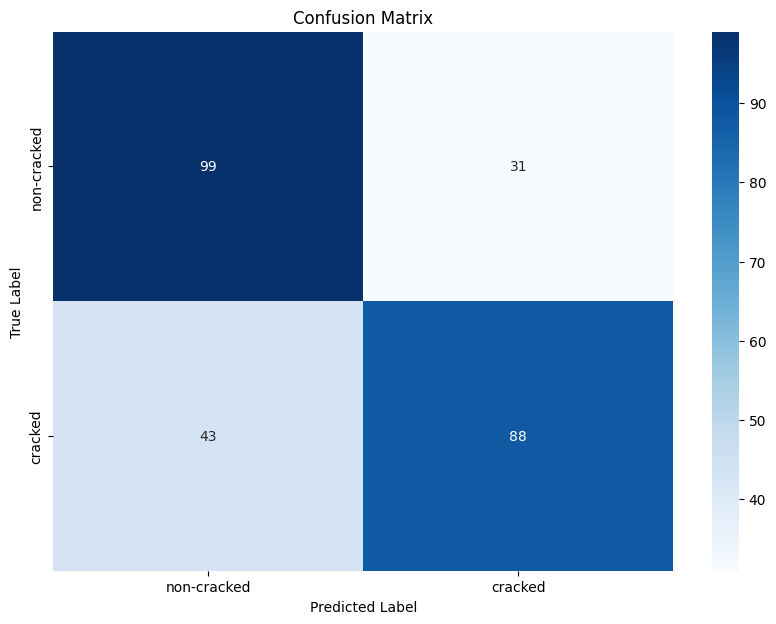

In [18]:
plot_conf_matrix(y_true, y_pred, classes=['non-cracked', 'cracked'])

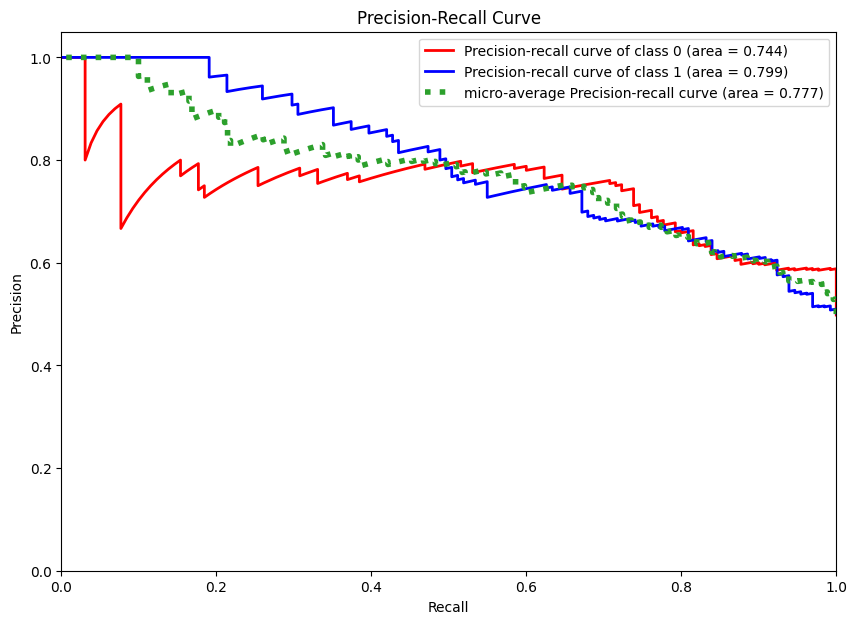

In [25]:
plot_precision_recall_curve(y_true, y_score)

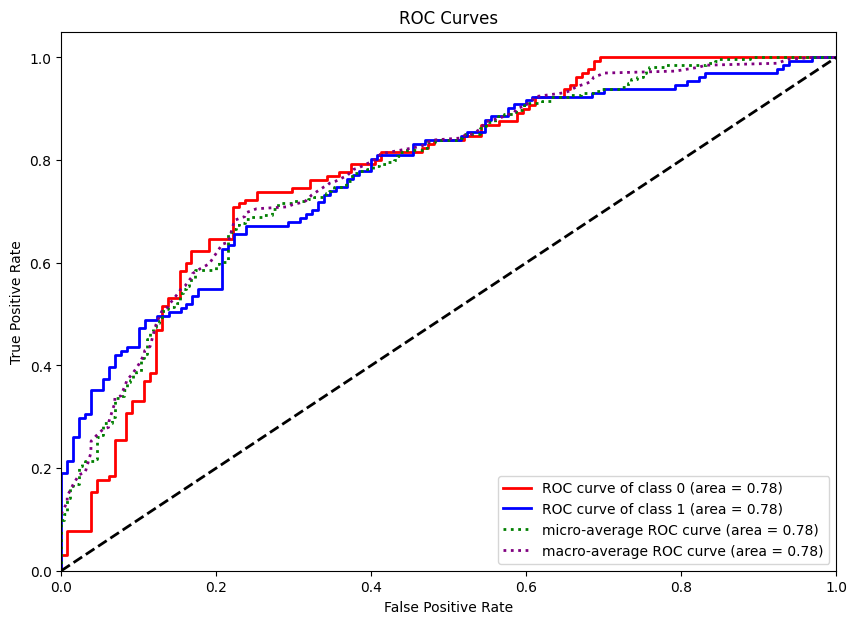

In [21]:
plot_roc_curve(y_true, y_score)

# Hyperparameter Optimization

In [79]:
# Training mode
PRETRAINED = True

In [80]:
def get_dataloaders(BATCH_SIZE, PRETRAINED):
    # define the input image dimensions
    IMG_SIZE = 224
    
    if PRETRAINED:
        MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
    else:
        MEAN, STD = calculate_mean_std(train_df.copy())

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD), 
        ]),
        'valid': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
        ])
    }

    dataloaders = {
        'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                            batch_size=BATCH_SIZE, shuffle=True, 
                            pin_memory=PIN_MEMORY),
        'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                            batch_size=BATCH_SIZE, shuffle=False, 
                            pin_memory=PIN_MEMORY),
        'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                           batch_size=1, shuffle=False,
                           pin_memory=PIN_MEMORY)
    }

    return dataloaders

In [81]:
# Define hyperparameter ranges
batch_size_list = [16, 32, 64]
epochs_list = [25, 50, 100]
learning_rate_list = [1.5e-4, 2.5e-5, 1.5e-5]

In [82]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

best_score = 0
best_params = None

num_classes = len(df.label.unique())

for batch_size in batch_size_list:
    for epochs in epochs_list:
        for learning_rate in learning_rate_list:
            dataloaders = get_dataloaders(batch_size, PRETRAINED)

            model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=PRETRAINED, trainable_layers=6)
            model = model.to(DEVICE)

            criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

            params_to_tune = [param for param in model.parameters() if param.requires_grad]
            optimizer = optim.SGD(params_to_tune, lr=learning_rate, momentum=0.9)

            scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-6)

            model_name = model.model_name
            dataset_name = dataloaders['train'].dataset.dataset_name

            save_dir = f"search_2/{model_name}_on_{dataset_name}_bsize_{batch_size}_epoch_{epochs}_lr_{learning_rate}"
            train(model, epochs, dataloaders, DEVICE, criterion, optimizer, scheduler=None, multiple_gpu=True, save_dir=save_dir, save=False, verbose=False)

            val_loss, val_acc = eval(model, dataloaders['valid'], criterion, DEVICE)
            if val_loss > best_score:
                best_score = val_loss
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'lr': learning_rate}

print("Best score:", best_score)
print("Best parameters:", best_params)


Best score: 0.5982830458804106
Best parameters: {'batch_size': 16, 'epochs': 100, 'lr': 0.00025}
